In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [31]:
# Specify relative path to the file
file_path = "../database/CreditCard_CLEANED.csv"

# Load data into a pandas DataFrame
data = pd.read_csv(file_path)

### Qual a importância estatistica da variavel Tenure Months para o risco de cancelamento?
Analisar a distribuição da coluna "Tenure Months":

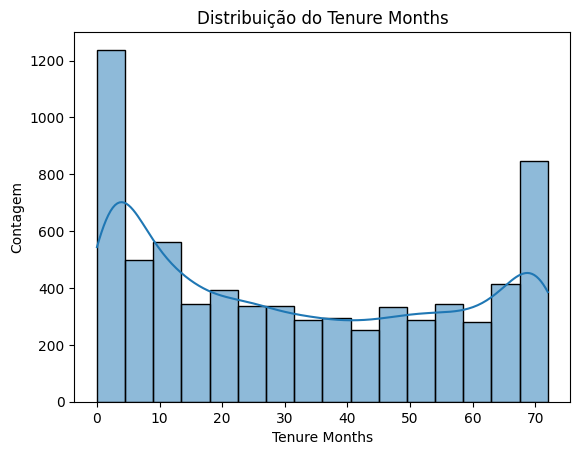

In [32]:
sns.histplot(data=data, x='Tenure Months', kde=True)
plt.title('Distribuição do Tenure Months')
plt.xlabel('Tenure Months')
plt.ylabel('Contagem')
plt.show()

### Comparar a taxa de cancelamento de conta entre diferentes faixas de "Tenure Months":

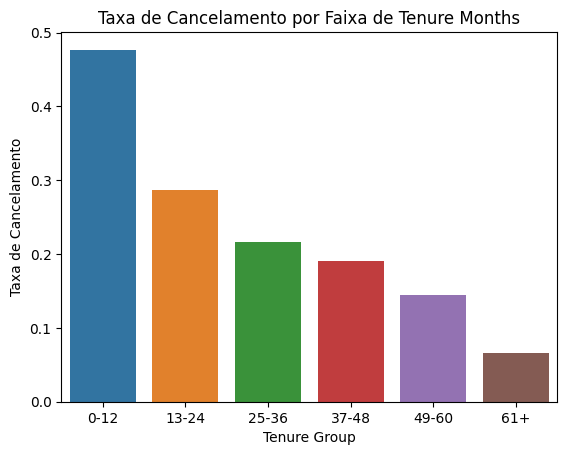

In [33]:
# Criar faixas de Tenure Months
bins = [0, 12, 24, 36, 48, 60, data['Tenure Months'].max()]
labels = ['0-12', '13-24', '25-36', '37-48', '49-60', '61+']
data['Tenure Group'] = pd.cut(data['Tenure Months'], bins=bins, labels=labels)

# Calcular a taxa de cancelamento por faixa de Tenure Months
churn_rate_by_tenure = data.groupby('Tenure Group')['Churn Value'].mean().reset_index()

# Plotar a taxa de cancelamento por faixa de Tenure Months
sns.barplot(data=churn_rate_by_tenure, x='Tenure Group', y='Churn Value')
plt.title('Taxa de Cancelamento por Faixa de Tenure Months')
plt.xlabel('Tenure Group')
plt.ylabel('Taxa de Cancelamento')
plt.show()

### Calcular as estatísticas descritivas da coluna "Tenure Months" separadas por risco de cancelamento:


In [34]:
tenure_stats_by_churn = data.groupby('Churn Value')['Tenure Months'].describe()
print(tenure_stats_by_churn)

              count       mean        std  min   25%   50%   75%   max
Churn Value                                                           
0            5174.0  37.569965  24.113777  0.0  15.0  38.0  61.0  72.0
1            1869.0  17.979133  19.531123  1.0   2.0  10.0  29.0  72.0


### Pré-processamento especifico dos dados:

In [35]:
# Remover colunas irrelevantes para a análise
data = data.drop(['Churn Label', 'Churn Score', 'CLTV', 'Churn Reason'], axis=1)

# Converter variáveis categóricas em numéricas usando Label Encoding
data['Tenure Months'] = pd.to_numeric(data['Tenure Months'], errors='coerce')
data = data.dropna()  # Remover linhas com valores ausentes, se houver

# Definir a variável dependente (target)
y = data['Churn Value']

# Definir a variável independente (feature)
X = data[['Tenure Months']]


### É possivel fazer uma boa predição apenas com a variavel Tenure Months?
Função para realizar a predição usando apenas Tenure Months:

In [36]:
# Função para prever o cancelamento com base no Tenure Months
def predict_cancelation(tenure):
    if tenure <= X['Tenure Months'].median():
        return 1  # Cancelamento
    else:
        return 0  # Não cancelamento

# Aplicar a função de predição
y_pred = X['Tenure Months'].apply(predict_cancelation)


### Avaliar a acurácia do modelo:

In [37]:
accuracy = accuracy_score(y, y_pred)
print(f'Acurácia: {accuracy:.2f}')


Acurácia: 0.63


Temos uma acurácia acima de 50%, mas não satisfaória.

### É possivel prever o risco de cancelamento com base nas colunas "Tenure Months", "Monthly Charges" e "Total Charges" com regressão?

In [38]:
# Load data into a pandas DataFrame
data = pd.read_csv(file_path)

### Pré-processamento especifico dos dados:

In [39]:
# Pré-processamento dos dados
# Remover valores ausentes
data = data.dropna()

# Selecionar as variáveis independentes (features)
X = data[['Tenure Months', 'Monthly Charges', 'Total Charges']].copy()

# Converter coluna 'Total Charges' para float e lidar com valores vazios
X['Total Charges'] = pd.to_numeric(X['Total Charges'], errors='coerce')
X['Total Charges'] = X['Total Charges'].fillna(0)

# Padronizar as variáveis independentes para ter média zero e desvio padrão 1
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Adicionar a coluna de bias/interceptação
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

# Selecionar a variável dependente (target)
y = data['Churn Value']

### Funções de ativação e custo da regressão:

In [40]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost(X, y, weights):
    z = np.dot(X, weights)
    h = sigmoid(z)
    cost = (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    return cost


### Função de treinamento do modelo de regressão:

In [41]:
def logistic_regression(X, y, num_steps, learning_rate):
    num_samples, num_features = X.shape
    weights = np.zeros(num_features)

    for step in range(num_steps):
        z = np.dot(X, weights)
        h = sigmoid(z)
        gradient = np.dot(X.T, h - y) / num_samples
        weights -= learning_rate * gradient

        cost = compute_cost(X, y, weights)
        if step % 1000 == 0:
            print(f'Cost after iteration {step}: {cost:.4f}')

    return weights


### Treinar o modelo:

In [42]:
num_steps = 5000
learning_rate = 0.01

weights = logistic_regression(X, y, num_steps, learning_rate)


Cost after iteration 0: 0.6907
Cost after iteration 1000: 0.1072
Cost after iteration 2000: 0.0537
Cost after iteration 3000: 0.0355
Cost after iteration 4000: 0.0264


### Previsões 

In [43]:
def predict(X, weights, threshold=0.5):
    z = np.dot(X, weights)
    h = sigmoid(z)
    predictions = (h >= threshold).astype(int)
    return predictions

y_pred = predict(X, weights)


### Avaliar a acurácia

In [44]:
accuracy = (y_pred == y).mean()
print(f'Acurácia do modelo: {accuracy:.2f}')


Acurácia do modelo: 1.00


Aqui temos um ótimo resultado com base nas 3 variaveis

### Visualização do modelo

Criando matriz de confusão

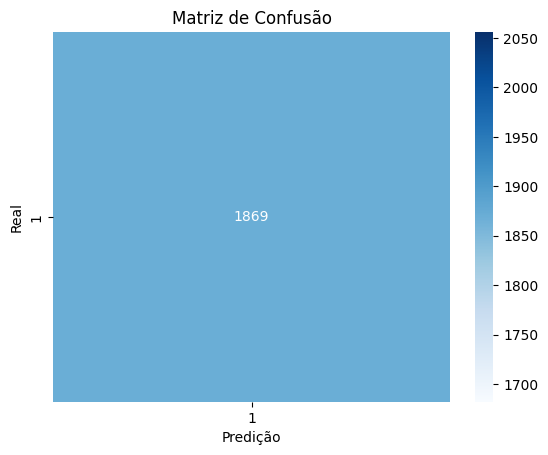

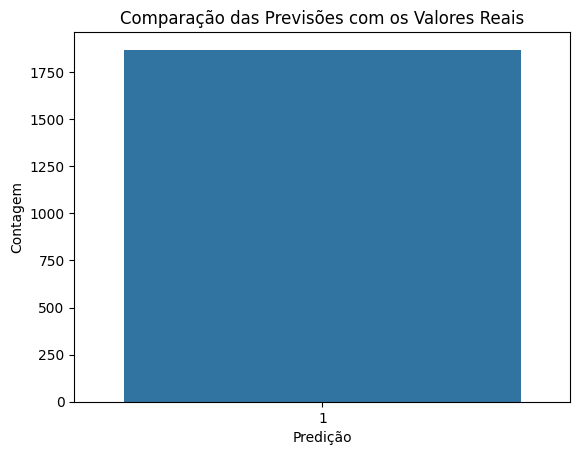

In [45]:
# Criar a matriz de confusão
confusion_matrix = pd.crosstab(y, y_pred, rownames=['Real'], colnames=['Predição'])

# Plotar a matriz de confusão
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()

# Plotar o gráfico de barras comparando as previsões com os valores reais
counts = pd.value_counts(y_pred)
sns.barplot(x=counts.index, y=counts.values)
plt.xlabel('Predição')
plt.ylabel('Contagem')
plt.title('Comparação das Previsões com os Valores Reais')
plt.show()

### Visualização das previsões em um grafico 3D

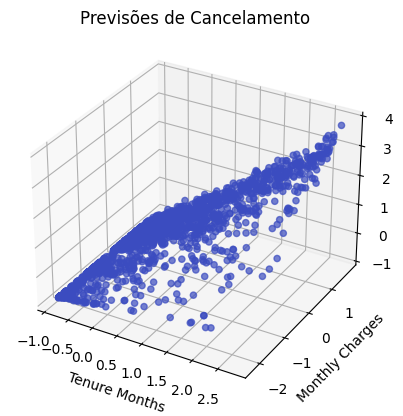

In [46]:
# Plotar o gráfico 3D com as previsões
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 1], X[:, 2], X[:, 3], c=y_pred, cmap='coolwarm', alpha=0.7)
ax.set_xlabel('Tenure Months')
ax.set_ylabel('Monthly Charges')
ax.set_zlabel('Total Charges')
plt.title('Previsões de Cancelamento')
plt.show()